In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RepeatedKFold, LeaveOneOut
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [4]:
data = pd.read_csv('house/train.csv')

data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [5]:
# Проверка на пропущенные значения
missing_values = data.isnull().sum()
print("Пропущенные значения в данных:")
print(missing_values[missing_values > 0])


Пропущенные значения в данных:
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [7]:
X = data.drop('SalePrice', axis=1)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#Нахождение атеориальных и числовых столбцов
categorical_columns = X_train.select_dtypes(include=['object']).columns
numeric_columns = X_train.select_dtypes(include=['number']).columns


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])


# Объединение трансформеров
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)


# Определение модели
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror'))
])

param_dist = {
    'regressor__n_estimators': [100, 200,],
    'regressor__max_depth': [3, 4],
    'regressor__learning_rate': [0.01, 0.02, 0.05, 0.1],
    'regressor__subsample': [0.2, 0.3, 0.5, 0.6, 0.8],
    'regressor__colsample_bytree': [0.6, 0.7,],
    'regressor__gamma': [0.1, 0.2],
    'regressor__reg_alpha': [0.1, 0.5, 0.75, 1, 1.5, 2,],
    'regressor__reg_lambda': [1, 1.5, 2,]
}

rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
loo = LeaveOneOut()

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=80,
    scoring='neg_mean_squared_error',
    cv=rkf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train, y_train)

# Результат
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")


# Запуск на тестовых данных
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

#Best parameters found: {'regressor__subsample': 0.8, 'regressor__reg_lambda': 1.5, 
# 'regressor__reg_alpha': 1, 'regressor__n_estimators': 100, 'regressor__max_depth': 3,
#  'regressor__learning_rate': 0.2, 'regressor__gamma': 0.2, 'regressor__colsample_bytree': 0.6
# MSE 15789

Fitting 50 folds for each of 80 candidates, totalling 4000 fits
Best parameters found: {'regressor__subsample': 0.5, 'regressor__reg_lambda': 2, 'regressor__reg_alpha': 0.1, 'regressor__n_estimators': 200, 'regressor__max_depth': 4, 'regressor__learning_rate': 0.05, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.6}
Best score: -927650077.5618252
MSE: 15305.508329765982
RMSE: 123.71543286819951


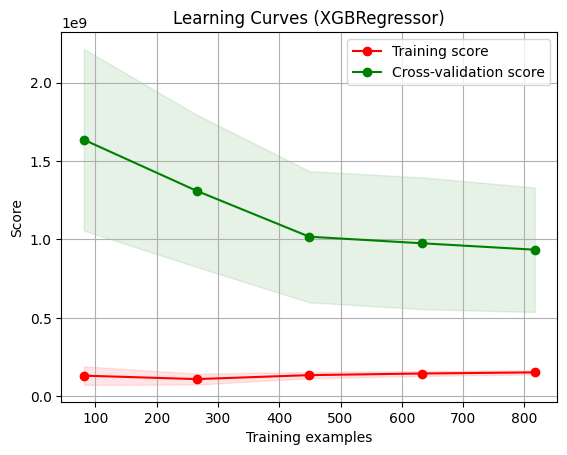

In [18]:
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

# Построение кривой обучения для лучшей модели
plot_learning_curve(best_model, "Learning Curves (XGBRegressor)", X_train, y_train, cv=rkf, n_jobs=-1)
plt.show()

In [9]:
import pickle

# Сохранение модели в файл
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Загрузка модели из файла (для проверки)
with open('xgb_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Проверка загруженной модели
y_pred = loaded_model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))


Mean Absolute Error: 15305.508329765982
